# PyTorch classification

Below is a clean, end‑to‑end PyTorch example you can run in Google Colab to train a strong CNN on Fashion‑MNIST. It includes data loading, on‑the‑fly augmentation, a compact CNN with batch norm and dropout, mixed precision, a modern One‑Cycle learning rate schedule, and automatic checkpointing.

Tip: In Colab, set Runtime → Change runtime type → Hardware accelerator → GPU before running.

## Official Page

https://pytorch.org/

In [1]:
# If running in Google Colab, this cell is enough to train/evaluate Fashion-MNIST.
# It uses a compact CNN, mixed precision, and OneCycleLR for fast convergence.

import os
import math
import time
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST

from tqdm.auto import tqdm
import numpy as np
import random

# ---------------------------
# 0) Reproducibility and device
# ---------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch: {torch.__version__}, TorchVision: {torchvision.__version__}")
if device.type == "cuda":
    print(torch.cuda.get_device_name())

# ---------------------------
# 1) Data: transforms, dataset, loaders
# ---------------------------
# Fashion-MNIST grayscale stats (approx)
MEAN, STD = 0.2861, 0.3530

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(28, padding=2, padding_mode="reflect"),
    transforms.ToTensor(),
    transforms.Normalize((MEAN,), (STD,)),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MEAN,), (STD,)),
])

data_root = "./data"

train_set = FashionMNIST(root=data_root, train=True, download=True, transform=train_tfms)
test_set  = FashionMNIST(root=data_root, train=False, download=True, transform=test_tfms)

# Validation split from train
val_ratio = 0.1667  # ~10k validation out of 60k
val_size = int(len(train_set) * val_ratio)
train_size = len(train_set) - val_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size], generator=torch.Generator().manual_seed(42))

batch_size = 128
num_workers = min(4, os.cpu_count() or 0)
pin_memory = device.type == "cuda"

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory, persistent_workers=num_workers > 0)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory, persistent_workers=num_workers > 0)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory, persistent_workers=num_workers > 0)

# ---------------------------
# 2) Model: compact, accurate CNN
# ---------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.drop = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.drop(x)
        return x

class FashionCNN(nn.Module):
    def __init__(self, num_classes=10, base=32, p_drop=0.25):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, base, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(base),
            nn.ReLU(inplace=True),
        )
        self.block1 = ConvBlock(base, base, dropout=p_drop)
        self.pool1  = nn.MaxPool2d(2)  # 28 -> 14
        self.block2 = ConvBlock(base, base*2, dropout=p_drop)  # increase channels
        self.pool2  = nn.MaxPool2d(2)  # 14 -> 7
        self.block3 = ConvBlock(base*2, base*4, dropout=p_drop)
        self.head   = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # global average pool to (C,1,1)
            nn.Flatten(),
            nn.Linear(base*4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if m.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(m.bias, -bound, bound)

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x); x = self.pool1(x)
        x = self.block2(x); x = self.pool2(x)
        x = self.block3(x)
        x = self.head(x)
        return x

model = FashionCNN().to(device)

# Optional: torch.compile for speed (PyTorch 2.x)
try:
    model = torch.compile(model)  # if not supported, this will raise and be ignored
    print("Model compiled with torch.compile")
except Exception as e:
    print(f"torch.compile unavailable or failed: {e}")

# ---------------------------
# 3) Optimizer, loss, scheduler, AMP
# ---------------------------
epochs = 15
lr_max = 3e-3

optimizer = AdamW(model.parameters(), lr=lr_max, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=lr_max,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.25,
    div_factor=10.0,
    final_div_factor=10.0,
    anneal_strategy="cos",
)

use_amp = device.type == "cuda"
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# ---------------------------
# 4) Training / evaluation loops
# ---------------------------
def accuracy(outputs, targets):
    preds = outputs.argmax(dim=1)
    return (preds == targets).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_n = 0
    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(images)
            loss = criterion(logits, labels)
        bs = images.size(0)
        total_loss += loss.item() * bs
        total_acc += accuracy(logits, labels) * bs
        total_n += bs
    return total_loss / total_n, total_acc / total_n

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    total_n = 0

    pbar = tqdm(loader, leave=False)
    for images, labels in pbar:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(images)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        bs = images.size(0)
        total_loss += loss.item() * bs
        total_acc += accuracy(logits, labels) * bs
        total_n += bs

        pbar.set_description(f"Train loss {total_loss/total_n:.4f} | acc {total_acc/total_n:.4f}")

    return total_loss / total_n, total_acc / total_n




Using device: cuda
PyTorch: 2.9.0+cu126, TorchVision: 0.24.0+cu126
Tesla T4


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.82MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 191kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.55MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 29.7MB/s]


Model compiled with torch.compile


/tmp/ipython-input-855270335.py:178: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


In [2]:
# ---------------------------
# 5) Train with checkpointing and early stop (by patience on val loss)
# ---------------------------
best_val_loss = float("inf")
best_val_acc = 0.0
patience = 5
patience_ctr = 0
ckpt_path = "best_fashion_mnist.pt"

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, epochs + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    improved = val_loss < best_val_loss - 1e-4
    if improved:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_ctr = 0
        torch.save({"model": model.state_dict()}, ckpt_path)
    else:
        patience_ctr += 1

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{epochs} | {dt:.1f}s  "
          f"train_loss {train_loss:.4f} acc {train_acc:.4f}  "
          f"val_loss {val_loss:.4f} acc {val_acc:.4f}  "
          f"{'(saved)' if improved else ''}")

    if patience_ctr >= patience:
        print("Early stopping: no improvement on val loss.")
        break

# ---------------------------
# 6) Load best model and evaluate on test set
# ---------------------------
if os.path.exists(ckpt_path):
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state["model"])
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test  loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  0%|          | 0/391 [00:00<?, ?it/s]

/tmp/ipython-input-855270335.py:215: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
W0116 13:29:31.903000 517 torch/_inductor/utils.py:1558] [0/0] Not enough SMs to use max_autotune_gemm mode
/tmp/ipython-input-85527033

Epoch 01/15 | 106.0s  train_loss 0.9382 acc 0.6748  val_loss 0.8577 acc 0.6719  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

/tmp/ipython-input-855270335.py:215: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 02/15 | 39.7s  train_loss 0.4878 acc 0.8210  val_loss 0.5596 acc 0.7949  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 03/15 | 31.7s  train_loss 0.4239 acc 0.8453  val_loss 0.6054 acc 0.7714  


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 04/15 | 31.2s  train_loss 0.3678 acc 0.8673  val_loss 0.5237 acc 0.8049  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 05/15 | 32.1s  train_loss 0.3350 acc 0.8775  val_loss 0.5227 acc 0.8011  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 06/15 | 31.1s  train_loss 0.3114 acc 0.8875  val_loss 0.4012 acc 0.8431  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 07/15 | 32.3s  train_loss 0.2935 acc 0.8924  val_loss 0.3967 acc 0.8502  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 08/15 | 31.1s  train_loss 0.2752 acc 0.8995  val_loss 0.3240 acc 0.8771  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 09/15 | 31.7s  train_loss 0.2619 acc 0.9044  val_loss 0.3215 acc 0.8784  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/15 | 31.5s  train_loss 0.2451 acc 0.9117  val_loss 0.3113 acc 0.8819  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11/15 | 31.0s  train_loss 0.2300 acc 0.9166  val_loss 0.2900 acc 0.8910  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12/15 | 32.4s  train_loss 0.2184 acc 0.9211  val_loss 0.2655 acc 0.8992  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13/15 | 31.3s  train_loss 0.2055 acc 0.9236  val_loss 0.2481 acc 0.9086  (saved)


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14/15 | 32.3s  train_loss 0.1996 acc 0.9264  val_loss 0.2578 acc 0.9013  


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15/15 | 31.2s  train_loss 0.1958 acc 0.9288  val_loss 0.2502 acc 0.9072  
Test  loss: 0.2313 | Test acc: 0.9179


In [3]:
!ls -l

total 1256
-rw-r--r-- 1 root root 1277269 Jan 16 13:37 best_fashion_mnist.pt
drwxr-xr-x 3 root root    4096 Jan 16 13:25 data
drwxr-xr-x 1 root root    4096 Dec  9 14:42 sample_data


In [4]:
# let's download the model
from google.colab import files
files.download('best_fashion_mnist.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Getting answers for particular item

/tmp/ipython-input-3637039618.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


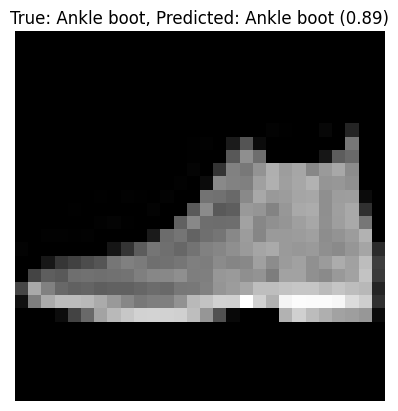

Actual label: Ankle boot
Predicted label: Ankle boot
Prediction confidence: 0.8853


In [5]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get the first batch from the test loader
images, labels = next(iter(test_loader))

# Get the first image and its true label
first_image = images[0]
true_label = labels[0].item()

# Move image to device and add a batch dimension for prediction
input_image = first_image.unsqueeze(0).to(device)

# Make prediction
model.eval()
with torch.no_grad():
    with torch.cuda.amp.autocast(enabled=use_amp):
        output = model(input_image)
    # we obtain all probabilities for this item
    probabilities = F.softmax(output, dim=1)
    # we find highest probability and its index
    predicted_prob, predicted_idx = torch.max(probabilities, 1)
predicted_label = predicted_idx.item()

# Unnormalize and display the image
# For visualization, we reverse the normalization
mean = np.array(MEAN)
std = np.array(STD)

img_display = first_image.cpu().numpy().transpose((1, 2, 0)) # C, H, W -> H, W, C
img_display = img_display * std + mean # Unnormalize
img_display = np.clip(img_display, 0, 1)

plt.imshow(img_display.squeeze(), cmap='gray')
plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[predicted_label]} ({predicted_prob.item():.2f})")
plt.axis('off')
plt.show()

print(f"Actual label: {class_names[true_label]}")
print(f"Predicted label: {class_names[predicted_label]}")
print(f"Prediction confidence: {predicted_prob.item():.4f}")

In [6]:
# let's show all probabilities
probabilities


tensor([[4.2319e-06, 1.0073e-05, 5.3644e-07, 5.4240e-06, 1.6093e-06, 1.4582e-03,
         7.1526e-07, 1.1304e-01, 1.1742e-05, 8.8525e-01]], device='cuda:0',
       dtype=torch.float16)